# Demo: Language Modeling
Demostrate typical usages for debugging a Language Model

### Defining a wrapper to use diagnostics tools

In [1]:
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F


class GPT2LMModelWrapper(nn.Module):
    def __init__(self, model) -> None:
        super(GPT2LMModelWrapper, self).__init__()
        self.m = model

    def forward(self, inputs_embeds, attention_mask) -> Tensor:
        output = self.m(
            inputs_embeds=inputs_embeds, attention_mask=attention_mask
        ).logits[:, -1, :]
        return F.softmax(output, -1)

### Language Modeling predicting next word using gpt2

In [2]:
import transformers
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

text_input = "Can humans dream of electric sheep ? This is a"
# text_input = "This knife is very"
# text_input = "Machine learning with pytorch and nn-diagnostics can do amazing"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2", return_dict=True, is_decoder=True)

inputs = tokenizer(text_input, return_tensors="pt")
output = model(**inputs).logits[:, -1, :]
softmax = F.softmax(output, -1)
values, predictions = softmax.topk(3)

for i, v in enumerate(values[0]):
    p = predictions[0][i]
    x = tokenizer.decode(p)
    print("prediction:", x, " prob:", v.item())

prediction:  question  prob: 0.1330832540988922
prediction:  very  prob: 0.0609452985227108
prediction:  great  prob: 0.03137362748384476


### Get input gradients and visualize

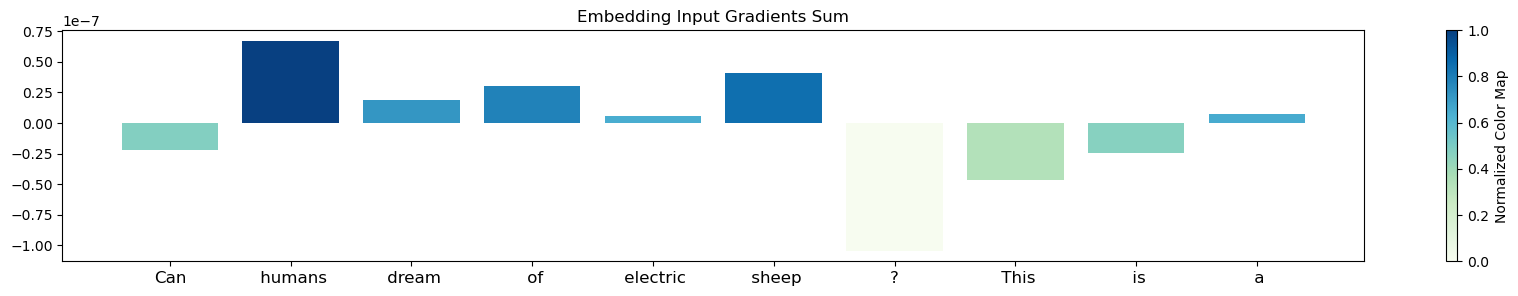

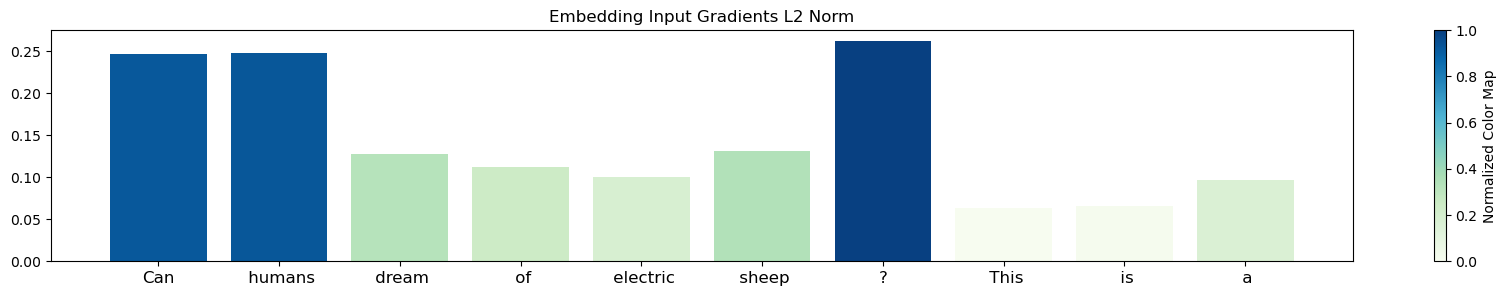

In [3]:
from diagnostics import get_input_gradients, get_integrated_gradients
from diagnostics.utils import plot_vector_gradients

# Preprocess inputs ids to embedings, otherwise we can't get gradients
inputs_embeds = model.transformer.wte(inputs["input_ids"])
# Use zero embeddings as baseline
baseline = [torch.zeros(inputs_embeds.shape), inputs["attention_mask"]]
# Set target to highest prob prediction
target = torch.zeros((1, tokenizer.vocab_size))
target[0][predictions[0][0]] = 1
md = GPT2LMModelWrapper(model)
input_grad = get_input_gradients(
    md, [inputs_embeds, inputs["attention_mask"]], baseline, target
)
input_grad_norm = torch.linalg.norm(input_grad[0], dim=2)

tokens = []
for i in inputs["input_ids"][0]:
    tokens.append(tokenizer.decode(i))

plot_vector_gradients(
    tokens, torch.sum(input_grad[0], dim=2)[0].numpy(), "Embedding Input Gradients Sum"
)
plot_vector_gradients(
    tokens, input_grad_norm[0].numpy(), "Embedding Input Gradients L2 Norm"
)

### Get Integrated gradients and visualize

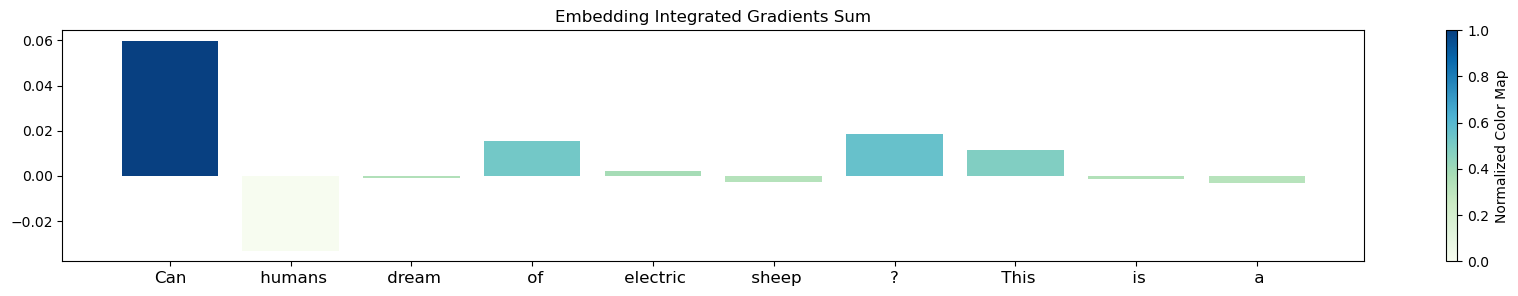

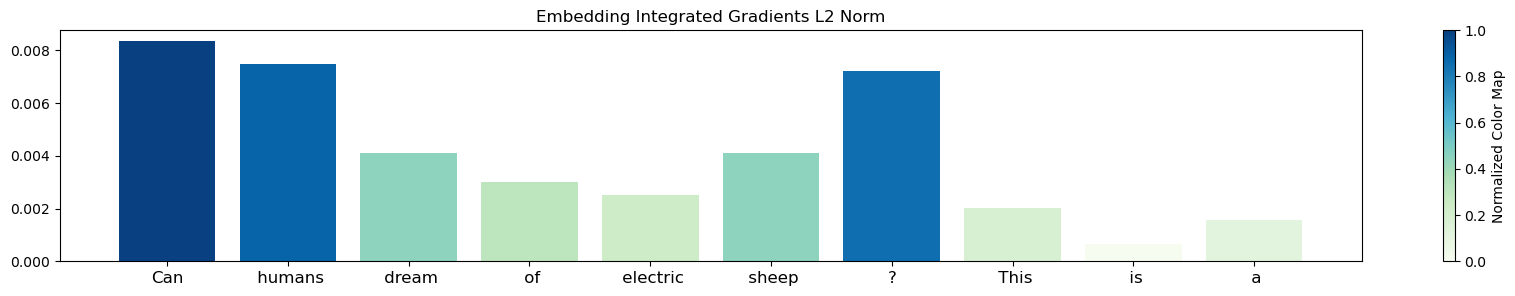

In [4]:
integraded_grad = get_integrated_gradients(
    md, [inputs_embeds, inputs["attention_mask"]], baseline, target
)
integraded_grad_norm = torch.linalg.norm(integraded_grad[0], dim=2)
plot_vector_gradients(
    tokens,
    torch.sum(integraded_grad[0], dim=2)[0].numpy(),
    "Embedding Integrated Gradients Sum",
)
plot_vector_gradients(
    tokens, integraded_grad_norm[0].numpy(), "Embedding Integrated Gradients L2 Norm"
)